## Import libraries

In [46]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import gridspec 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from sklearn.metrics import ConfusionMatrixDisplay
import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

## Read data

In [2]:
ddf = pd.read_csv("creditcard.csv") 

In [3]:
ddf.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## EDA

In [4]:
print(ddf.shape) 
print(ddf.describe())

(284807, 31)
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271

In [5]:
# Determine number of fraud cases in dataset 
fraud = ddf[ddf['Class'] == 1] 
valid = ddf[ddf['Class'] == 0] 
outlierFraction = len(fraud)/float(len(valid)) 
print(outlierFraction) 
print('Fraud Cases: {}'.format(len(ddf[ddf['Class'] == 1]))) 
print('Valid Transactions: {}'.format(len(ddf[ddf['Class'] == 0]))) 

0.0017304750013189597
Fraud Cases: 492
Valid Transactions: 284315


In [6]:
print('Amount details of the fraudulent transaction') 
fraud.Amount.describe() 

Amount details of the fraudulent transaction


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [7]:
print('details of valid transaction') 
valid.Amount.describe()

details of valid transaction


count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

## Missing values

In [8]:
total = ddf.isnull().sum().sort_values(ascending = False)
percent = (ddf.isnull().sum()/ddf.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V16,Amount,V28,V27,V26,V25,V24,V23,V22,V21,V20,V19,V18,V17,V15,V1,V14,V13,V12,V11,V10,V9,V8,V7,V6,V5,V4,V3,V2,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
ddf.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

There is no missing data in the entire dataset.

## Data unbalance

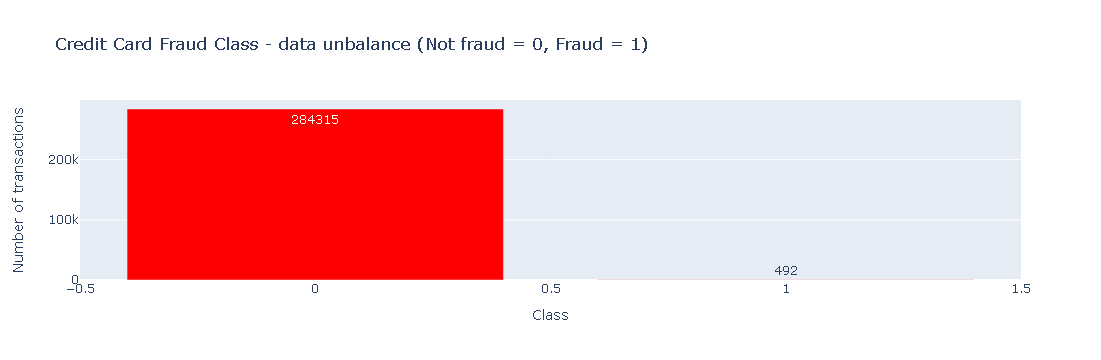

In [10]:
temp = ddf["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

284807 - 284315 = 492

Only 492 (or 0.172%) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable Class.

## Data exploration

### Transactions in time

In [11]:
ddf.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


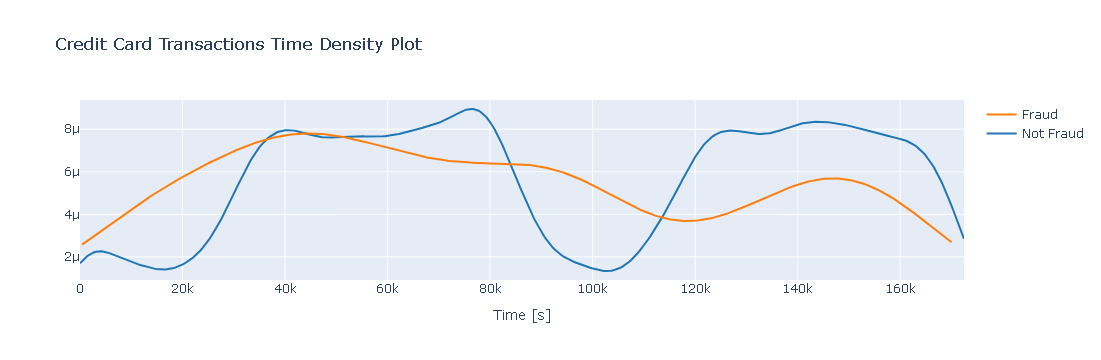

In [12]:
class_0 = ddf.loc[ddf['Class'] == 0]["Time"]
class_1 = ddf.loc[ddf['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

In [13]:
ddf['Hour'] = ddf['Time'].apply(lambda x: np.floor(x / 3600))

tmp = ddf.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


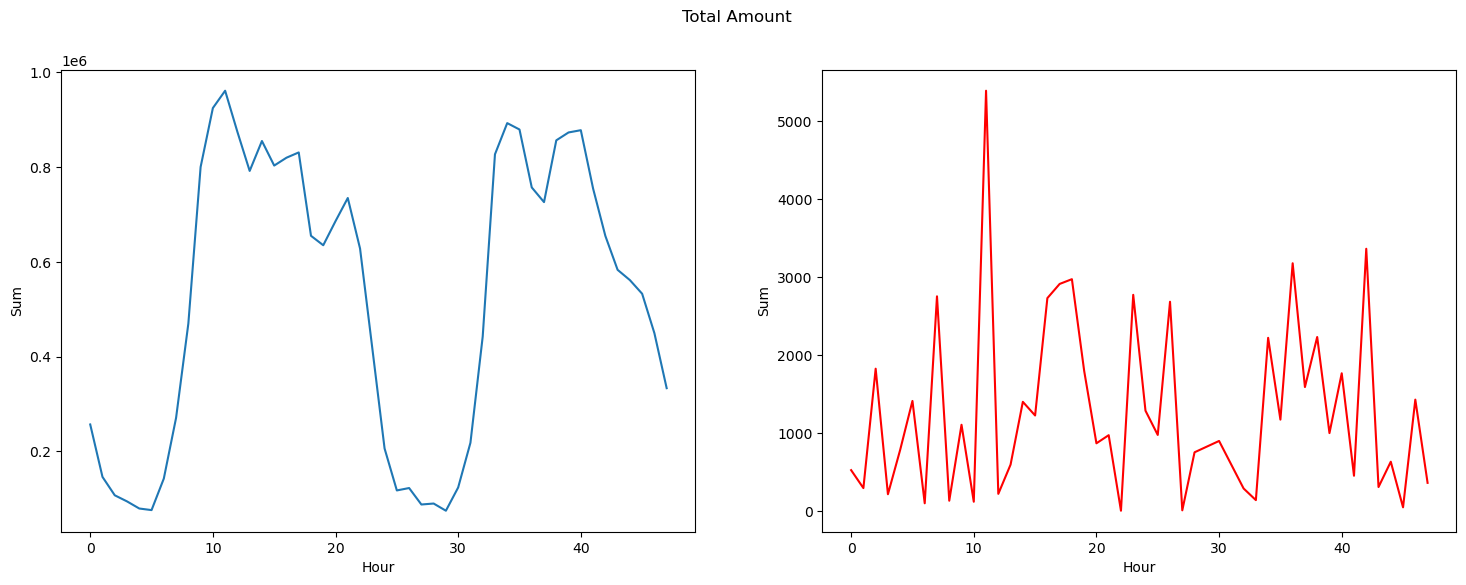

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

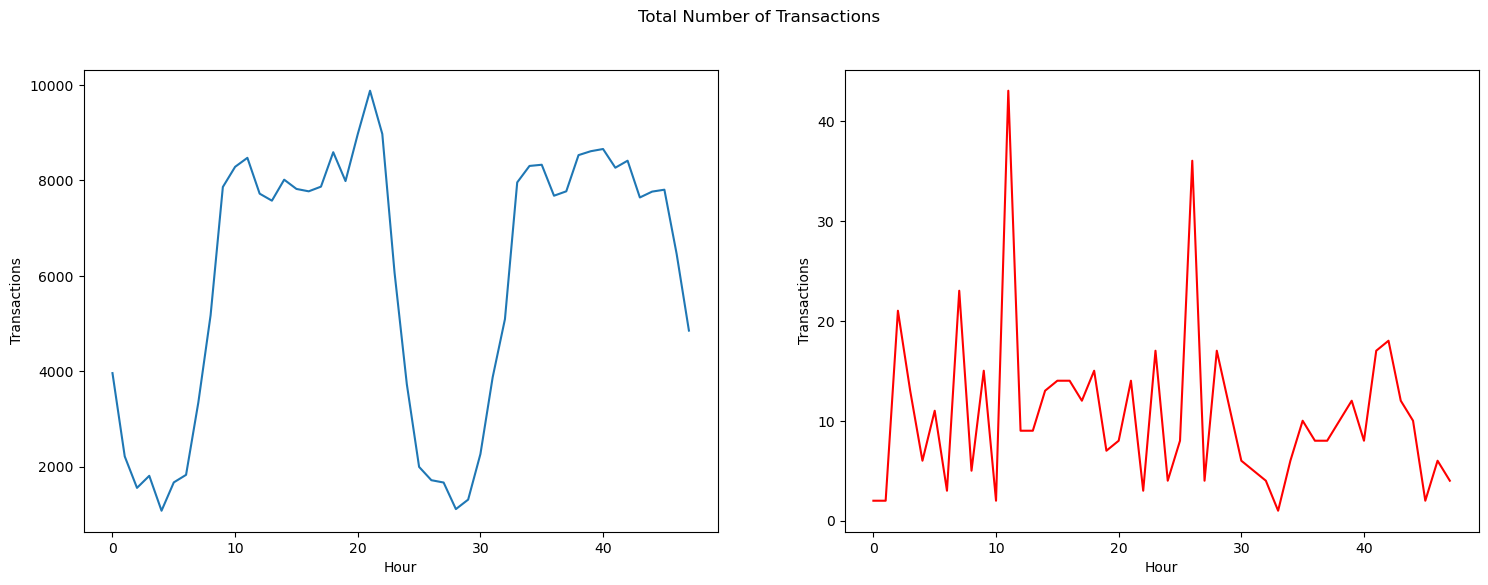

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

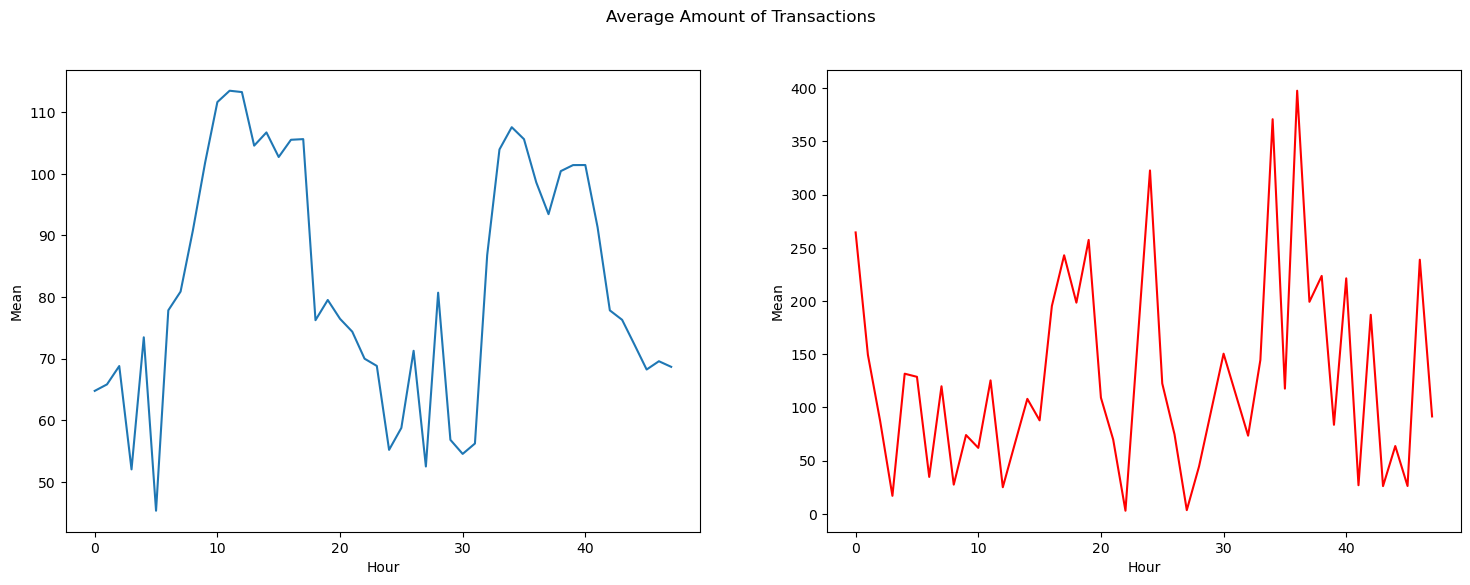

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show();

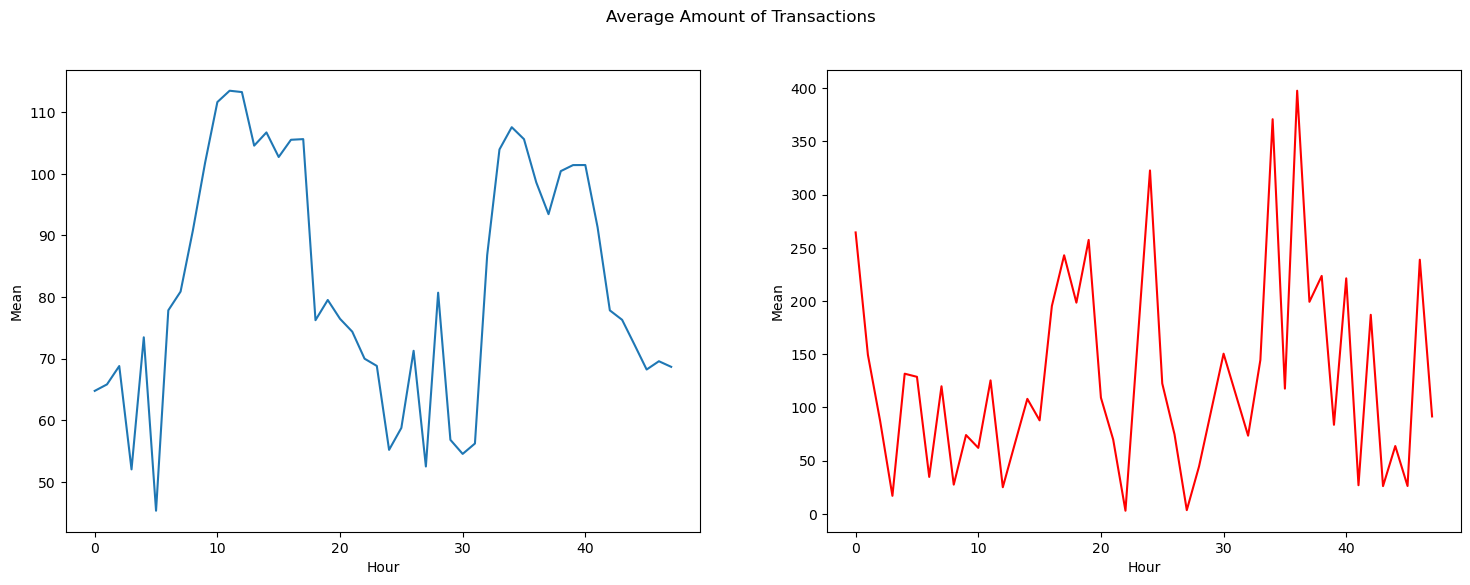

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show();

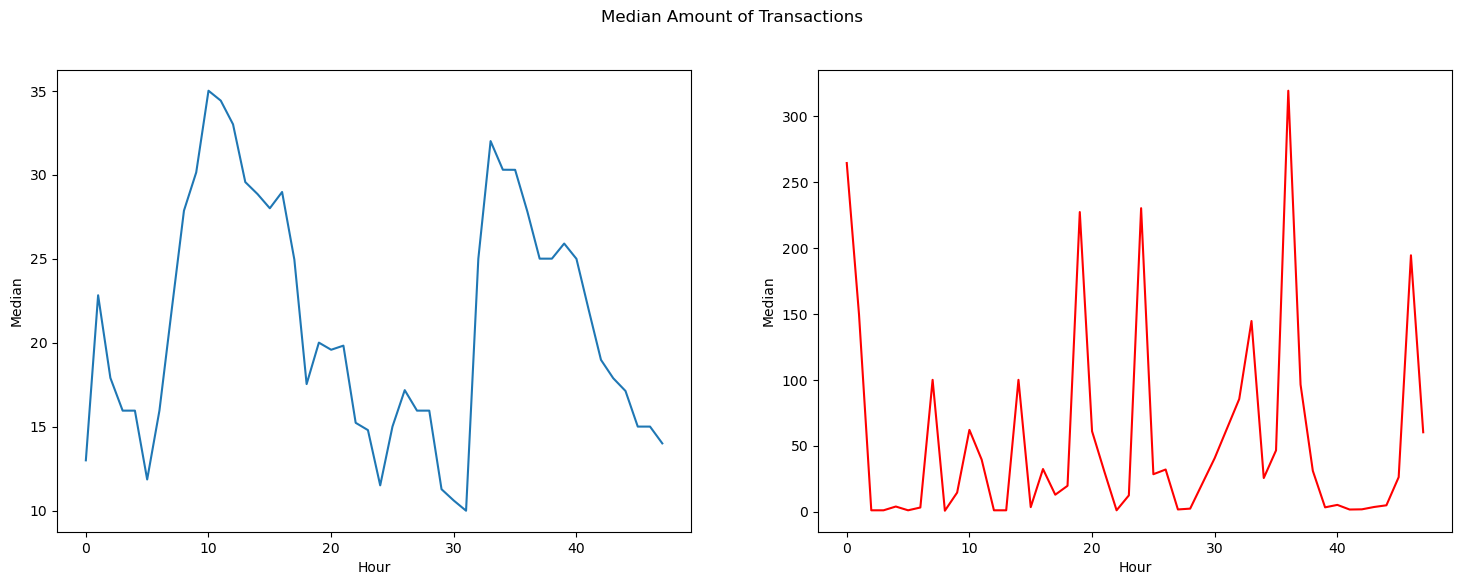

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show();

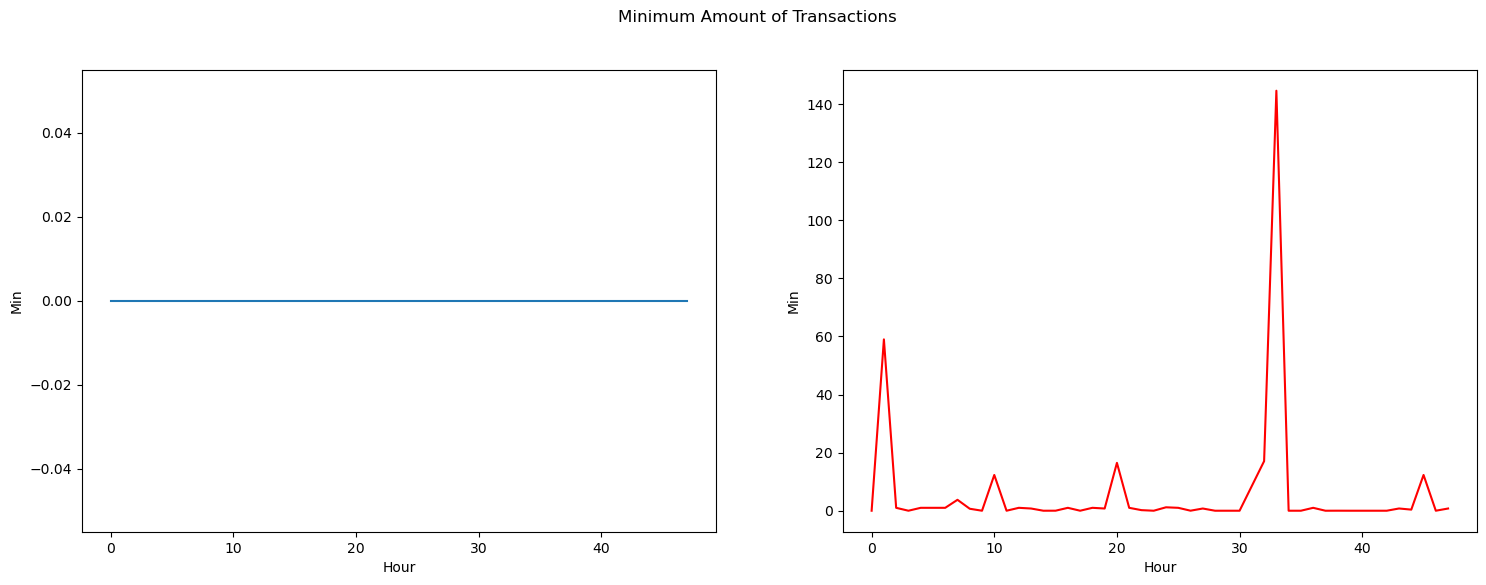

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show()

### Transactions amount

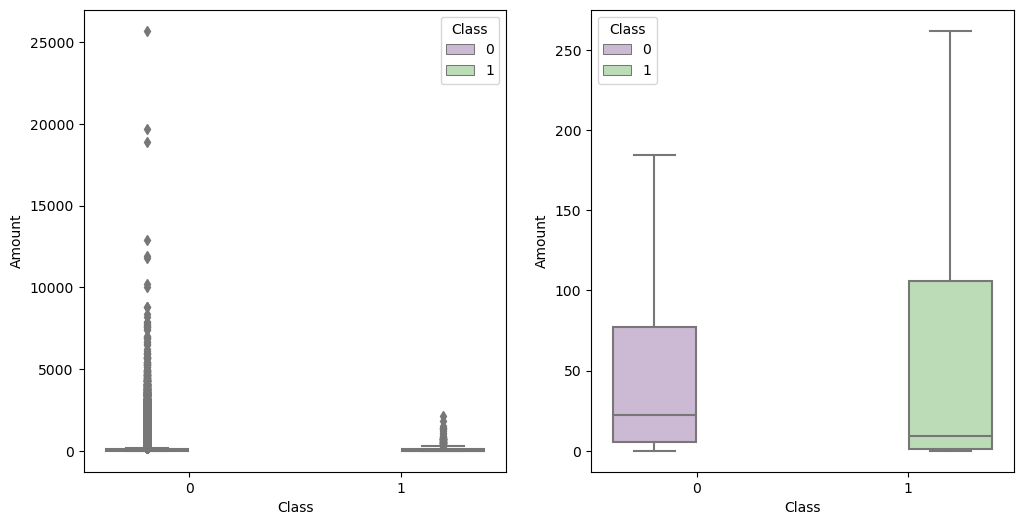

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=ddf, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=ddf, palette="PRGn",showfliers=False)
plt.show();

In [21]:
tmp = ddf[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [22]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

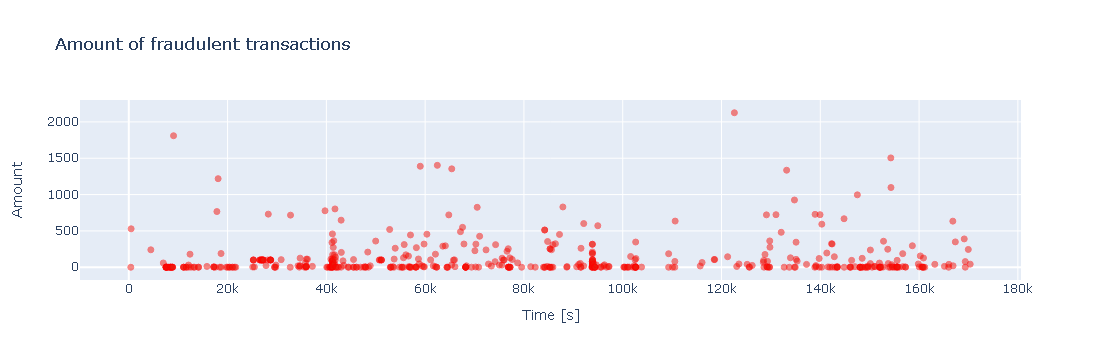

In [23]:
fraud = ddf.loc[ddf['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

## Features correlation

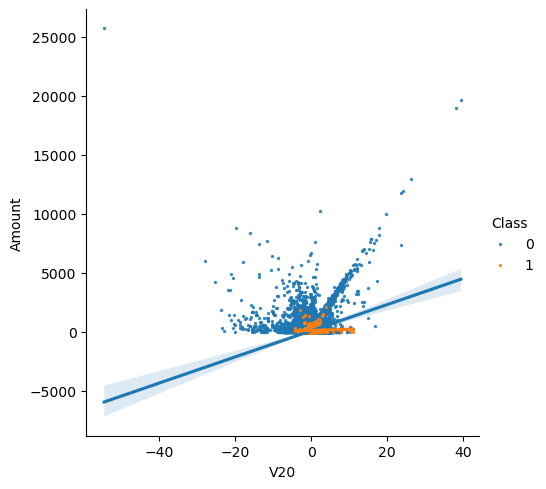

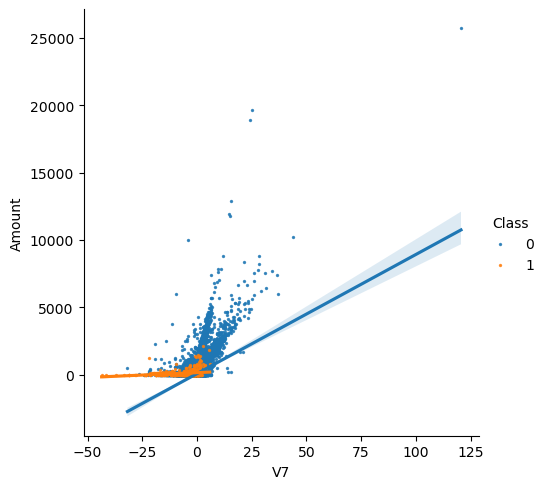

In [24]:
s = sns.lmplot(x='V20', y='Amount',data=ddf, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=ddf, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

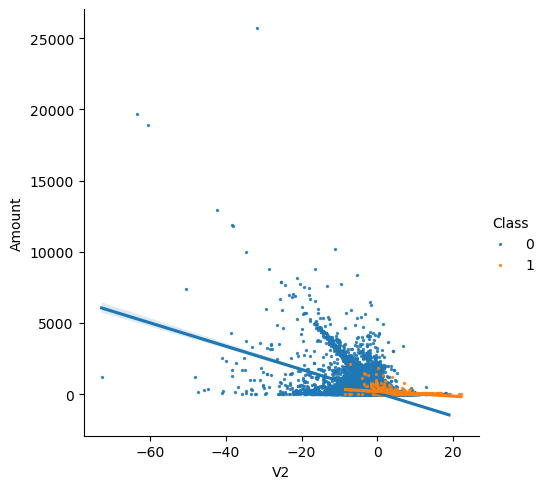

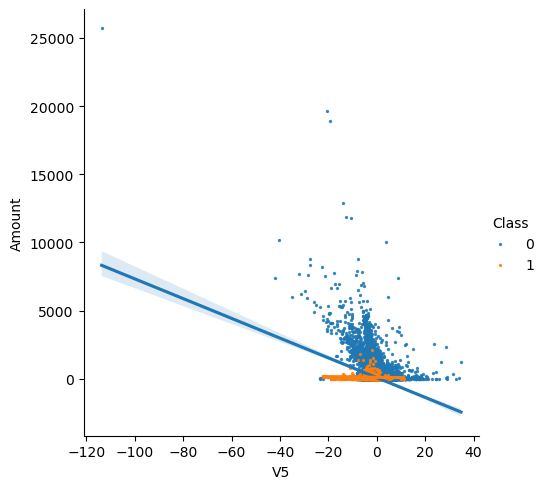

In [25]:
s = sns.lmplot(x='V2', y='Amount',data=ddf, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=ddf, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

<Figure size 640x480 with 0 Axes>

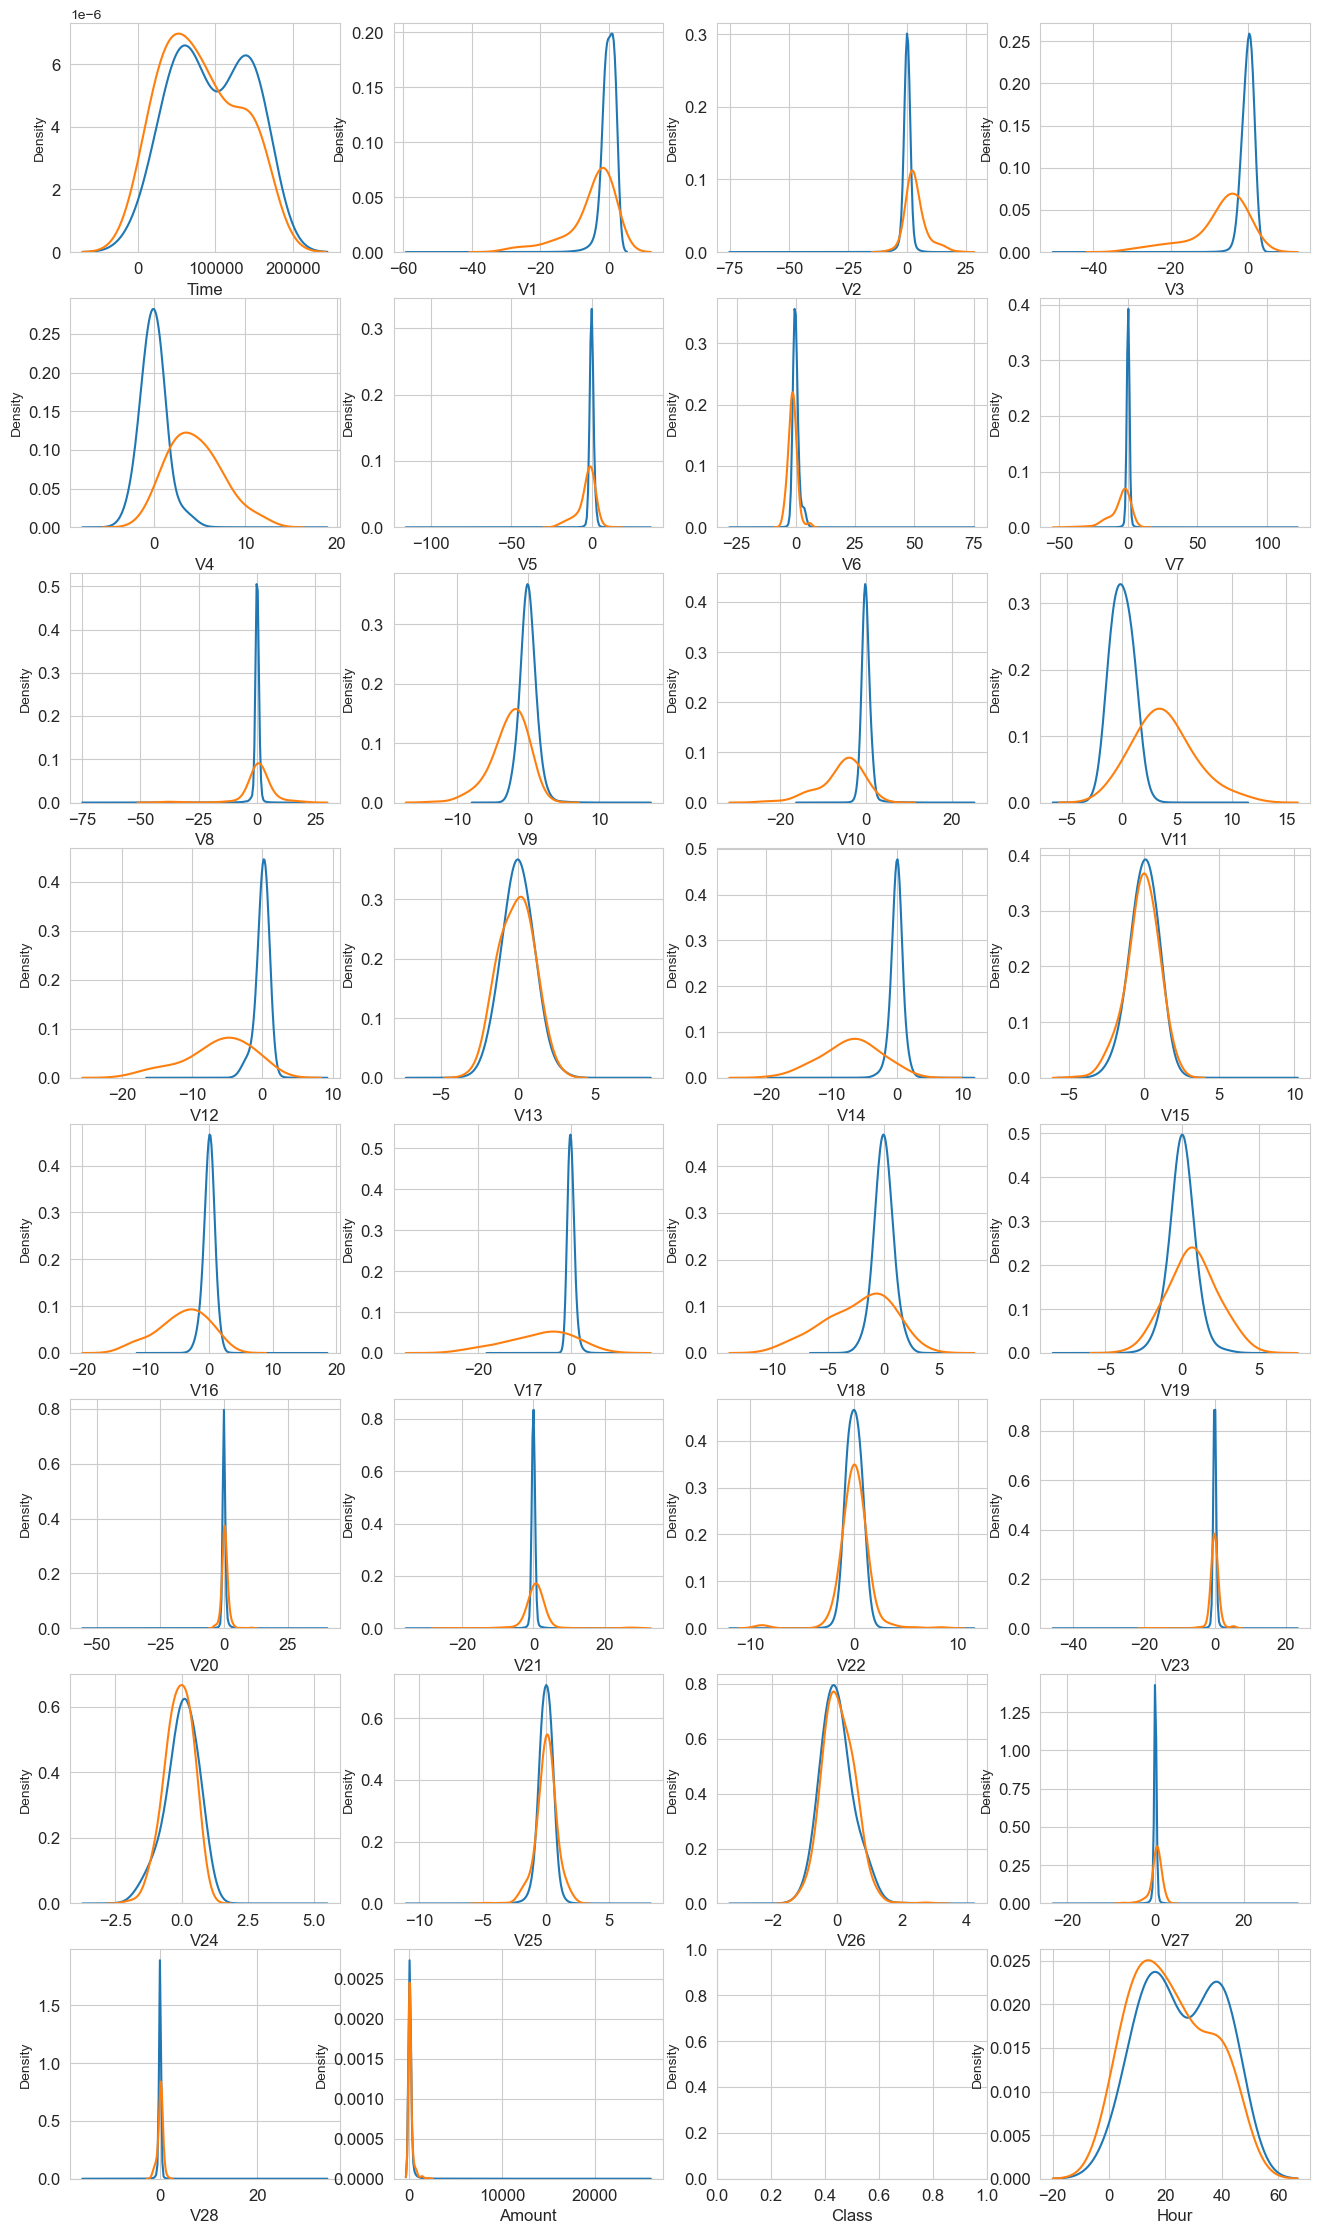

In [26]:
var = ddf.columns.values

i = 0
t0 = ddf.loc[ddf['Class'] == 0]
t1 = ddf.loc[ddf['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

### Define predictors and target values

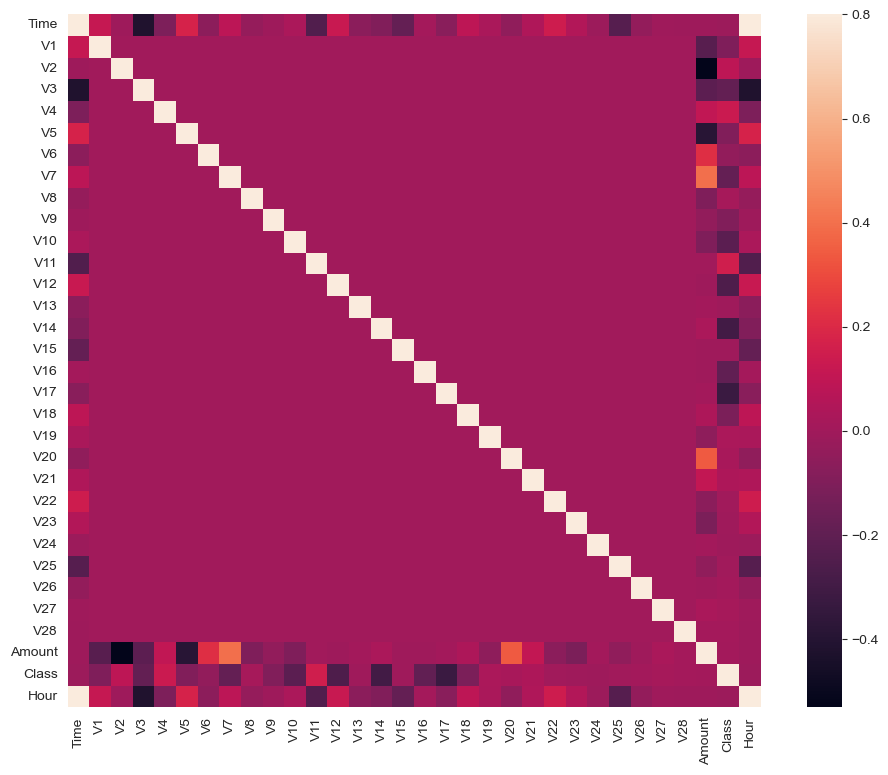

In [27]:
# Correlation matrix 
corrmat = ddf.corr() 
fig = plt.figure(figsize = (12, 9)) 
sns.heatmap(corrmat, vmax = .8, square = True) 
plt.show()

In [28]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

### Split data in train, test and validation set

In [29]:
train_df, test_df = train_test_split(ddf, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(ddf, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [30]:
train_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour
92870,64147.0,-0.639689,0.999967,1.449687,1.381592,-0.196913,0.001674,0.834650,0.009472,-0.251383,-0.031482,-0.325606,0.215470,-0.257880,0.007579,0.221147,-1.298635,0.735555,-0.781574,0.600996,0.094515,-0.007281,0.323076,-0.081904,0.426820,-0.141606,-0.254721,0.330366,0.188553,71.33,0,17.0
244749,152471.0,-1.614711,-2.406570,0.326194,0.665520,2.369268,-1.775367,-1.139049,0.329904,0.903813,-0.219013,-1.726259,-0.736771,-1.516835,0.348343,0.041437,0.732681,-1.136766,0.816653,-1.578951,0.419835,0.701399,1.134489,0.965054,0.640981,-1.801998,-1.041114,0.286285,0.437322,96.00,0,42.0
193610,130212.0,2.118051,-1.847058,-0.051490,-1.570773,-1.892229,0.155288,-1.881601,0.185238,-0.762622,1.619989,0.247584,-0.203794,0.373739,-0.699036,-0.519833,0.164157,0.000185,0.839657,0.022570,-0.328637,-0.087908,0.174339,0.255677,-0.499525,-0.563995,-0.239315,0.055737,-0.036884,60.00,0,36.0
35775,38257.0,0.766274,-1.145390,0.857432,0.379459,-1.314489,0.132728,-0.529121,0.201428,1.343793,-0.560580,-0.757043,0.084960,-1.107642,-0.261315,0.095821,-0.333832,0.492086,-0.910847,0.048313,0.243105,-0.093072,-0.497909,-0.059808,0.141480,-0.049919,0.953375,-0.063672,0.044809,216.20,0,10.0
251893,155549.0,-0.065119,1.075350,-0.985967,-0.042260,0.235107,-1.257180,0.767013,0.150977,-0.179045,-1.250954,-0.765755,-0.466433,-0.589618,-0.470093,0.774626,0.200989,0.745521,0.806258,-0.259306,-0.167716,0.361910,0.945477,-0.019850,-0.180283,-0.348097,-0.145189,-0.018516,0.041948,55.00,0,43.0


In [ ]:
## Model creation

## Different models train and test

make classification report

measure ROC_AOC_SCORE

Feature importance

confusion matrix

Random Forest Classification Report on validation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.96      0.77      0.86       100

    accuracy                           1.00     56962
   macro avg       0.98      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962


Random Forest Classification Report on testing:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.96      0.77      0.86       100

    accuracy                           1.00     56962
   macro avg       0.98      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962


Random Forest ROC_AOC curve on validation:
0.8849736203439907

Random Forest ROC_AOC curve on testing:
0.8849736203439907



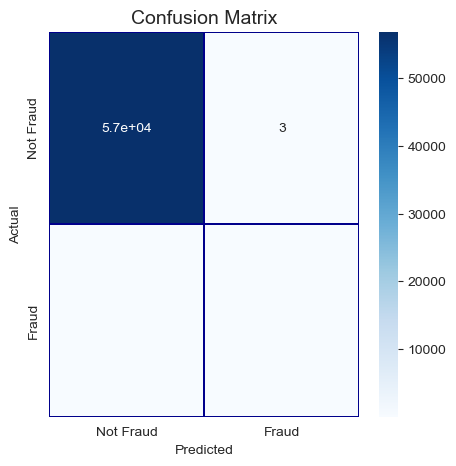

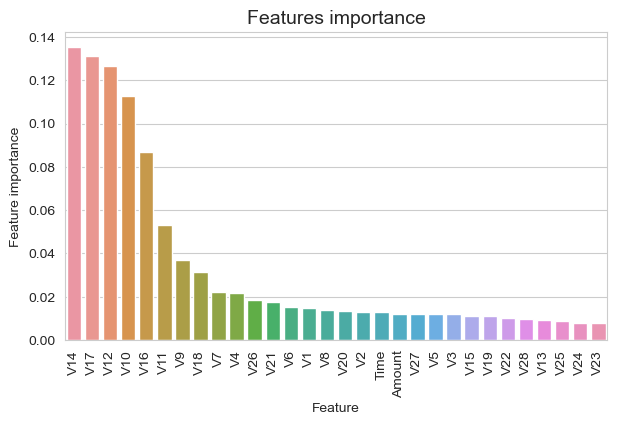

SVM Classification Report on validation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.00      0.00      0.00       100

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962


SVM Classification Report on testing:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.00      0.00      0.00       100

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962


SVM ROC_AOC curve on validation:
0.5

SVM ROC_AOC curve on testing:
0.5



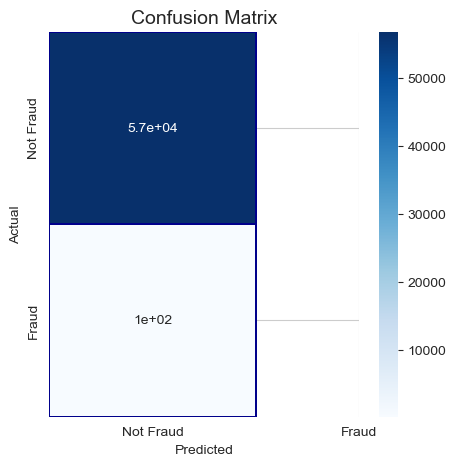

K-Nearest Neighbors Classification Report on validation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       1.00      0.08      0.15       100

    accuracy                           1.00     56962
   macro avg       1.00      0.54      0.57     56962
weighted avg       1.00      1.00      1.00     56962


K-Nearest Neighbors Classification Report on testing:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       1.00      0.08      0.15       100

    accuracy                           1.00     56962
   macro avg       1.00      0.54      0.57     56962
weighted avg       1.00      1.00      1.00     56962


K-Nearest Neighbors ROC_AOC curve on validation:
0.54

K-Nearest Neighbors ROC_AOC curve on testing:
0.54



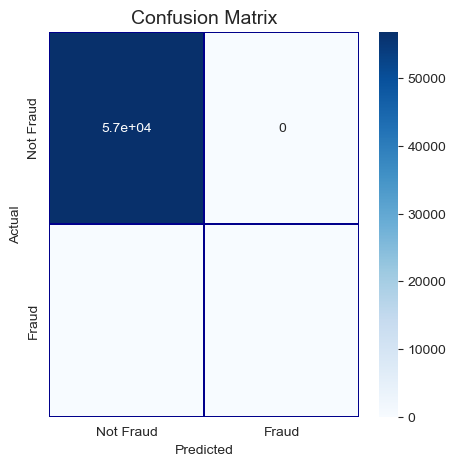

Decision Tree Classification Report on validation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.81      0.75      0.78       100

    accuracy                           1.00     56962
   macro avg       0.90      0.87      0.89     56962
weighted avg       1.00      1.00      1.00     56962


Decision Tree Classification Report on testing:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.81      0.75      0.78       100

    accuracy                           1.00     56962
   macro avg       0.90      0.87      0.89     56962
weighted avg       1.00      1.00      1.00     56962


Decision Tree ROC_AOC curve on validation:
0.8748417220639443

Decision Tree ROC_AOC curve on testing:
0.8748417220639443



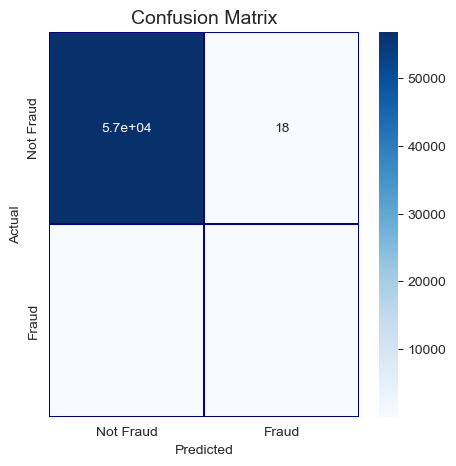

In [35]:
# Define the models
models = {'Random Forest': RandomForestClassifier(random_state=0),
          'SVM': SVC(random_state=0),
          'K-Nearest Neighbors': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(random_state=0),
         }

# Train and evaluate each model
for name, model in models.items():
    model.fit(train_df[predictors], train_df[target].values)
    
    y_pred = model.predict(valid_df[predictors])
    preds = model.predict(test_df[predictors])
    
    print(f"{name} Classification Report on validation:\n{classification_report(valid_df[target].values, y_pred)}\n")
    print(f"{name} Classification Report on testing:\n{classification_report(test_df[target].values, preds)}\n")
    
    print(f"{name} ROC_AOC curve on validation:\n{roc_auc_score(valid_df[target].values, y_pred)}\n")
    print(f"{name} ROC_AOC curve on testing:\n{roc_auc_score(test_df[target].values, preds)}\n")
    
    cm = pd.crosstab(valid_df[target].values, y_pred, rownames=['Actual'], colnames=['Predicted'])
    fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
    sns.heatmap(cm, 
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'],
                annot=True,ax=ax1,
                linewidths=.2,linecolor="Darkblue", cmap="Blues")
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()

    if name == 'Random Forest':            
        tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': model.feature_importances_})
        tmp = tmp.sort_values(by='Feature importance',ascending=False)
        plt.figure(figsize = (7,4))
        plt.title('Features importance',fontsize=14)
        s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
        plt.show()   

# The Model will now classify new data into playlists

## Finding hyper-parameter

In [37]:
classifier = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)
classifier.fit(train_df[predictors],train_df[target])

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

In [40]:
# Define the parameter grid to tune the hyperparameters
param_grid = {
    'max_depth': [4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(classifier, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(train_df[predictors],train_df[target])

# Get the best model
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print(best_model.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


In [42]:
model_DTC = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=5, min_samples_split=10, min_samples_leaf=1, random_state=42)
model_DTC.fit(train_df[predictors],train_df[target])

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=10,
                       random_state=42)

## New accurecy with hyper-parameter

Train F1_Score:  0.9995303824968729
test F1_Score:  0.9994557775359011
Confusion matric on training


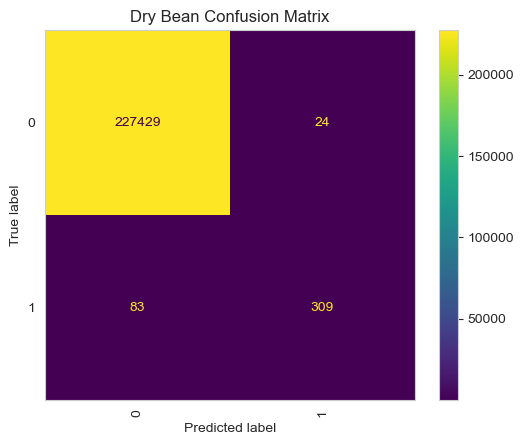

Confusion matric on testing


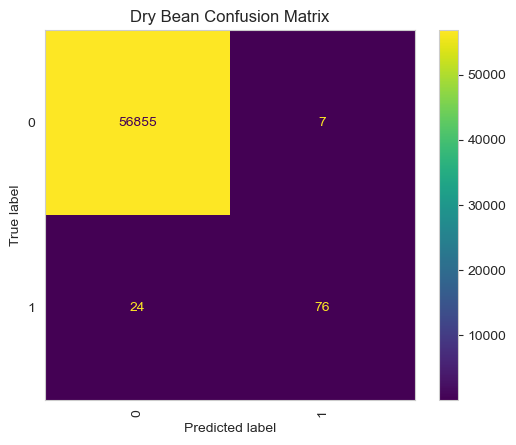

In [50]:
print("Train F1_Score: ", metrics.f1_score(train_df[target], model_DTC.predict(train_df[predictors]), average='micro'))
print("test F1_Score: ", metrics.f1_score(test_df[target].values, model_DTC.predict(test_df[predictors]), average='micro'))

# Displaying Results in Confusion Matrix

print('Confusion matric on training')
ConfusionMatrixDisplay.from_estimator(model_DTC, train_df[predictors], train_df[target])  

plt.xticks(rotation=90)
plt.grid(False)
plt.title('Dry Bean Confusion Matrix')
plt.show()

print('Confusion matric on testing')
ConfusionMatrixDisplay.from_estimator(model_DTC, test_df[predictors], test_df[target])  

plt.xticks(rotation=90)
plt.grid(False)
plt.title('Dry Bean Confusion Matrix')
plt.show() 

## Conclusion:

By desision Tree we got 99% accuracy